<a href="https://colab.research.google.com/github/alexandergrishin/suitar/blob/master/Body_part_segmentation_on_no_bg_photo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing PoseNet

In [0]:
 # Clone the repo and install 3rd-party libraries. 
!git clone https://www.github.com/ildoonet/tf-openpose 
%cd tf-openpose
!pip3 install -r requirements.txt

# Build c++ library for post processing. See : https://github.com/ildoonet/tf-pose-estimation/tree/master/tf_pose/pafprocess
%cd tf_pose/pafprocess
!sudo apt install swig
!swig -python -c++ pafprocess.i && python3 setup.py build_ext --inplace
%cd ../..

Cloning into 'tf-openpose'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 1312 (delta 3), reused 7 (delta 2), pack-reused 1301
Receiving objects: 100% (1312/1312), 94.12 MiB | 607.00 KiB/s, done.
Resolving deltas: 100% (692/692), done.
/content/tf-openpose/tf-openpose
  Cloning https://github.com/ppwwyyxx/tensorpack.git to /tmp/pip-req-build-3gnq42ff
  Stored in directory: /tmp/pip-ephem-wheel-cache-wx1j7v3b/wheels/a8/b5/a9/025b3a1294b9ffff93309e6956c65aa80e0fa40821d29eff1e
Successfully built tensorpack
/content/tf-openpose/tf-openpose/tf_pose/pafprocess
Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.12-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 10 not 

# Test the Posenet api

## Upload image from google drive

In [0]:
!pip install PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile
from google.colab import files
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Требования к фотографии:


1.   На фото должен быть один человек в одежде по фигуре. К примеру: майка,  тонкая кофта по фигуре.
2.   Руки расставленны чуть в стороны, чтоб между рукой и туловищем было пространство
3.   Ноги **не** вместе
### Чтоб загрузить фото нужно:


1.   Загрузить фото на гугл диск и скопировать общедоступную ссылку на файл
2.   Скопировать id файла и вставить с воотвецтвующий параметр как в коде ниже 

Например, в ссылке 
https://drive.google.com/file/d/1DhYW8OwLG-bpxN8x6rCocZE9Fs4L1m57/view?usp=sharing

id файла: 1DhYW8OwLG-bpxN8x6rCocZE9Fs4L1m57





In [0]:
# https://drive.google.com/file/d/1UipgdGRzsiHFbjUiPs_YKCSbzDqpS_zR/view?usp=sharing
# https://drive.google.com/file/d/1DhYW8OwLG-bpxN8x6rCocZE9Fs4L1m57/view?usp=sharing

download = drive.CreateFile({'id': '1CYqSn4PFWpVpTZ6VUp4kvs8qXK-3rg1w'})
download.GetContentFile('file.jpg')
download = drive.CreateFile({'id': '1DhYW8OwLG-bpxN8x6rCocZE9Fs4L1m57'})
download.GetContentFile('file1.jpg')
download = drive.CreateFile({'id': '1DhYW8OwLG-bpxN8x6rCocZE9Fs4L1m57'})
download.GetContentFile('file2.jpg')


# Remove background

In [0]:
import requests
api_key = '756u7RGGWUD6B5AYPwUjXmhZ'
def get_no_bg_img(path, api_key):
    API_KEY = api_key
    headers = {
        'X-API-Key': API_KEY,
    }

    files = {
        'image_file': (path, open(path, 'rb')),
    }

    response = requests.post('https://api.remove.bg/v1.0/removebg', headers=headers, files=files)
    return response

In [0]:
path = 'file1.jpg'
no_bg_path = 'new_no_bg.png'
response = get_no_bg_img(path, api_key)
with open(no_bg_path,'wb') as f:
    f.write(response.content)


In [0]:
# to download file without background
files.download(no_bg_path)

# Getting pose

In [0]:
import math
def get_contour(orign_img, new_img, on_mask=True):
  img = cv2.imread(orign_img)
  new_img = cv2.imread(new_img)
  
  # create mask
  mask = img.copy()
  for i in range(len(mask)):
    for j in range(len(mask[0])):
      if (img[i][j] != np.array([0,0,0])).all():
        mask[i][j] = np.array([255,255,255])
  
  imgray = cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)
  ret,thresh = cv2.threshold(imgray,127,255,0)
  im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
  if on_mask == True:
    img_2 = cv2.drawContours(mask, contours, -1, (0,255,0), 3)
  else:
    img_2 = cv2.drawContours(new_img, contours, -1, (0,255,0), 3)

  return img_2, mask

In [0]:
""" Functions for body part segmentation."""


def find_biggest_contour(image):
    # Copy
    mask = image.copy()
    #input, gives all the contours, contour approximation compresses horizontal,
    #vertical, and diagonal segments and leaves only their end points. For example,
    #an up-right rectangular contour is encoded with 4 points.
    #Optional output vector, containing information about the image topology.
    #It has as many elements as the number of contours.
    #we dont need it
    for i in range(len(mask)):
      for j in range(len(mask[0])):
        if (image[i][j] != np.array([0,0,0])).all():
          mask[i][j] = np.array([255,255,255])
    imgray = cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(imgray,127,255,0)
    im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    # Isolate largest contour
    contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
    biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]

    mask = np.zeros(image.shape, np.uint8)
    return biggest_contour, mask 

def get_neck_coords(x0,y0, x1, y1):
    x = int(min(x0, x1) + abs(x0-x1) / 2)
    y = int(min(y0, y1) + abs(y0-y1) * 3 / 5)
    return x, y

def get_armpit_coords(contour, centers, arm):
    def y(p, d1, d2):
        if d1[0] != d2[0]:
          m = (d1[1]-d2[1]) / (d1[0] - d2[0])
        else:
          m = 0
        b = d1[1] - m * d1[0]
        
        y = m * p[:,0] + b
        
        return y < p[:,1]
    c = contour

    if arm == 'left':
      left_dot, right_dot, top_dot, bot_dot = centers[3], centers[8], centers[2], centers[8]
      left_dot = min(left_dot[0],top_dot[0]) + abs(top_dot[0] - left_dot[0])/3, left_dot[1]
      ind5 = y(c[:,0,:], centers[3], centers[2]).reshape(c[:,:,0].shape)

    
        
    if arm == 'right':
      left_dot, right_dot, top_dot, bot_dot = centers[8], centers[6], centers[5], centers[11]

      right_dot = min(right_dot[0], top_dot[0]) + abs(top_dot[0] - right_dot[0])/3, right_dot[1]
      ind5 = y(c[:,0,:], centers[5], centers[6]).reshape(c[:,:,0].shape)

  
    ind3 = c[:,:,0]>left_dot[0]
    ind4 = c[:,:,0]<right_dot[0]
    
    ind = c[:,:,1]>top_dot[1] 
    ind2 = c[:,:,1]<bot_dot[1]
    ind = ind * ind2 * ind3 * ind4 * ind5
    c = contour[ind]
    extLeft = tuple(c[c[:, 0].argmin()])
    extRight = tuple(c[c[:, 0].argmax()])
    extTop = tuple(c[c[:, 1].argmin()])
    extBot = tuple(c[c[:, 1].argmax()])
    extTop = extTop[0], extTop[1]

    return extLeft, extRight, extTop, extBot
  
def getPerpCoord(aX, aY, bX, bY, length):
    vX = bX-aX
    vY = bY-aY
    if vX == 0:

      return bX, bY + length, bX, bY - length

    if vY == 0:
      
      return bX + length, bY, bX - length, bY

    mag = math.sqrt(vX*vX + vY*vY)
    vX = vX / mag
    vY = vY / mag
    temp = vX
    vX = 0-vY
    vY = temp
    cX = bX + vX * length
    cY = bY + vY * length
    dX = bX - vX * length
    dY = bY - vY * length
    return int(cX), int(cY), int(dX), int(dY)

def getVector(aX, aY, bX, bY):
    vX = bX-aX
    vY = bY-aY
    return vX, vY
  
def is_black(img, x, y):

    if (img[x][y] != (0,0,0)).all():
      return True
    else:
      return False

def get_line(img, x1,y1,x2,y2):
  nimg = img.copy()
  with_line = cv2.line(img, (x1,y1), (x2,y2), [0,255,0], 3)
  line_ind = (nimg != with_line).all(axis=-1)
  nimg[line_ind] = [0,0,255]
  return nimg

def extend_line(img, biggest_contour,x1, y1, x2, y2, armpit=False):
  
    copy_img = img.copy()
    contured_img = cv2.drawContours(copy_img, [biggest_contour], -1, [0,255,0], 3)

    ind_contour = (contured_img==[0,255,0]).all(axis=-1)

    #slope
    if x1 != x2:
      m = (y1-y2)/(x1-x2)
    else:
      m = 0
    b = y1 - m * x1
    
    ax = max(x1, x2)
    ay = int(round(m * ax + b))
    
    bx = min(x1, x2)
    by = int(round(m * bx + b))
    
    # Удлиняем отрезки, пока не пересечемся с контуром тела
    while not ind_contour[ay][ax]:
        ax +=1
        ay = int(round(m * ax + b))
        if abs(ay) >= ind_contour.shape[0] or abs(ax) >= ind_contour.shape[1]:
          break
          
    while not ind_contour[by][bx]:
        bx -=1
        by = int(round(m * bx + b))
        if abs(by) >= ind_contour.shape[0] or abs(bx) >= ind_contour.shape[1]:
          break
      
        
    return ax, ay, bx, by
  
def neck_parts(p, d1, d2):
        """p - contour dots list"""
        
        if d1[0] != d2[0]:
          m = (d1[1]-d2[1]) / (d1[0] - d2[0])
        else:
          m = 0
        b = d1[1] - m * d1[0]
        
        med_y = min(d1[1], d2[1]) + abs(d1[1]-d2[1]) / 2 
        max_y = max(d1[1], d2[1])
        ind = (p[:,1] > med_y) * (p[:,1] < max_y)
        y1 = m * p[:,0] + b
        x1 = np.round((p[:,1] - b) / m)
        ind_l = x1 > p[:,0]
        ind_l = ind_l * ind

        ind_r = x1 < p[:,0]
        ind_r = ind_r * ind

        return {'left_part': ind_l, 'right_part': ind_r}

def find_min_dist(contour, ind_l, ind_r):
    left_part = contour[ind_l][:,-1]
    right_part = contour[ind_r][:,-1]
    
    min_dist = 1000000
    dots = []
    for i in left_part:
      for j in right_part:
        dist = np.sqrt((i[0]-j[0])**2 + (i[1]-j[1])**2)
        if dist < min_dist:
          min_dist = dist
          dots = ((i[0],i[1]), (j[0],j[1]))
          
    return dots

    
def get_neck_coords(contour, centers):
    
    parts = neck_parts(contour[:,0,:], centers[0], centers[1])
    left_ind = parts['left_part']

    right_ind = parts['right_part']

    p1, p2 = find_min_dist(contour, left_ind, right_ind)

    return p1, p2


In [0]:
def draw_humans(npimg, humans, imgcopy=False, fill_white=False):
        if imgcopy:
            npimg = np.copy(npimg)
        image_h, image_w = npimg.shape[:2]
        centers = {}
        for human in humans:
            # draw point
            for i in range(common.CocoPart.Background.value):
                if i not in human.body_parts.keys():
                    continue
                
                body_part = human.body_parts[i]
                center = (int(body_part.x * image_w + 0.5), int(body_part.y * image_h + 0.5))
                centers[i] = center
            
            # find contour
            biggest_contour, mask  = find_biggest_contour(npimg)


            # draw line
            for pair_order, pair in enumerate(common.CocoPairsRender):
                if pair[0] not in human.body_parts.keys() or pair[1] not in human.body_parts.keys():
                    continue
                if pair == (1,8) or pair == (1,11):
                    continue
            
            pairs = [(6,7), (5,6), (2,5), (1,5), (5,2), (2,3), (3,4)]
            pairs = [(6,7), (5,6), (2,3), (3,4), (8,9), (9,10),(11,12), (12,13)]

            
            for pair in pairs:
                
                line_coords = getPerpCoord(*centers[pair[0]], *centers[pair[1]], 3)
                p1 = (line_coords[0],line_coords[1])
                p2 = (line_coords[2],line_coords[3])
                x1, y1, x2, y2 = extend_line(npimg,biggest_contour, *p1, *p2)
                npimg = get_line(npimg, x1, y1, x2, y2)
            
            # neck 
            p1, p2 = get_neck_coords(biggest_contour, centers)
            cv2.circle(npimg, p1, 3, (255, 0, 0), -1)
            cv2.circle(npimg, p2, 3, (255, 0, 0), -1)
            x1, y1, x2, y2 = extend_line(npimg, biggest_contour, *p1, *p2)
            npimg = get_line(npimg, x1, y1, x2, y2)
            
            # left arm
            extLeft, extRight, extTop, extBot = get_armpit_coords(biggest_contour, centers, 'left')
            x1, y1, x2, y2 = extend_line(npimg,biggest_contour, *centers[2],*extTop, armpit=True)
            npimg = get_line(npimg, x1, y1, x2, y2)

            # right arm
            extLeft, extRight, extTop, extBot = get_armpit_coords(biggest_contour, centers, 'right')
            x1, y1, x2, y2 = extend_line(npimg,biggest_contour,  *centers[5],*extTop, armpit=True)
            npimg = get_line(npimg, x1, y1, x2, y2)
            
            # legs
            x1, y1, x2, y2 = extend_line(npimg,biggest_contour, *centers[8], *centers[11])
            npimg = get_line(npimg, x1, y1, x2, y2)
            
            # draw contour
            npimg = cv2.drawContours(npimg, [biggest_contour], -1, [0,0, 255], 3)
            conture = (npimg==[0,0,255]).all(axis=-1)
            
            # neck 
            p1, p2 = get_neck_coords(biggest_contour, centers)
            cv2.circle(npimg, p1, 3, (255, 0, 0), -1)
            cv2.circle(npimg, p2, 3, (255, 0, 0), -1)
            x1, y1, x2, y2 = extend_line(npimg, biggest_contour, *p1, *p2)
            npimg = get_line(npimg, x1, y1, x2, y2)
            
            # fill contour white colour
            if fill_white:
              npimg = cv2.drawContours(npimg, [biggest_contour], -1, [255,255, 255], -1)
              npimg[conture] = (0,0,255)

        return npimg

In [0]:
import argparse
import logging
import sys
import time

from tf_pose import common
import cv2
import numpy as np
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh
logger = logging.getLogger('TfPoseEstimator')
logger.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
w, h = model_wh('432x368')
if w == 0 or h == 0:
    e = TfPoseEstimator(get_graph_path('mobilenet_thin'), target_size=(432, 368))
else:
    e = TfPoseEstimator(get_graph_path('mobilenet_thin'), target_size=(w, h))

def pose_estimate(image_path, fill_white=False):
    
        
    # estimate human poses from a single image !
    image = common.read_imgfile(image_path, None, None)
    if image is None:
        logger.error('Image can not be read, path=%s' % image)
        sys.exit(-1)
    t = time.time()
    humans = e.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=4.0)
    print(humans)
    elapsed = time.time() - t

    logger.info('inference image: %s in %.4f seconds.' % (image_path, elapsed))
#     image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)
#     contured_img, mask = get_contour(image_path, image_path, on_mask=False)
  
    image = draw_humans(image, humans, imgcopy=False, fill_white=fill_white)
    
    
    return image, humans


[2019-03-19 19:09:08,356] [TfPoseEstimator] [INFO] loading graph from /content/tf-openpose/models/graph/mobilenet_thin/graph_opt.pb(default size=432x368)
[2019-03-19 19:09:08,356] [TfPoseEstimator] [INFO] loading graph from /content/tf-openpose/models/graph/mobilenet_thin/graph_opt.pb(default size=432x368)
[2019-03-19 19:09:08,356] [TfPoseEstimator] [INFO] loading graph from /content/tf-openpose/models/graph/mobilenet_thin/graph_opt.pb(default size=432x368)
[2019-03-19 19:09:08,356] [TfPoseEstimator] [INFO] loading graph from /content/tf-openpose/models/graph/mobilenet_thin/graph_opt.pb(default size=432x368)
[2019-03-19 19:09:08,356] [TfPoseEstimator] [INFO] loading graph from /content/tf-openpose/models/graph/mobilenet_thin/graph_opt.pb(default size=432x368)
[2019-03-19 19:09:08,356] [TfPoseEstimator] [INFO] loading graph from /content/tf-openpose/models/graph/mobilenet_thin/graph_opt.pb(default size=432x368)
[2019-03-19 19:09:08,356] [TfPoseEstimator] [INFO] loading graph from /conte

[2019-03-19 19:09:15,547] [TfPoseEstimator] [DEBUG] inference+ original shape=433x577
[2019-03-19 19:09:15,547] [TfPoseEstimator] [DEBUG] inference+ original shape=433x577
[2019-03-19 19:09:15,547] [TfPoseEstimator] [DEBUG] inference+ original shape=433x577
[2019-03-19 19:09:15,547] [TfPoseEstimator] [DEBUG] inference+ original shape=433x577
[2019-03-19 19:09:15,547] [TfPoseEstimator] [DEBUG] inference+ original shape=433x577
[2019-03-19 19:09:15,547] [TfPoseEstimator] [DEBUG] inference+ original shape=433x577
[2019-03-19 19:09:15,547] [TfPoseEstimator] [DEBUG] inference+ original shape=433x577
[2019-03-19 19:09:15,547] [TfPoseEstimator] [DEBUG] inference+ original shape=433x577
[2019-03-19 19:09:15,547] [TfPoseEstimator] [DEBUG] inference+ original shape=433x577
[2019-03-19 19:09:15,547] [TfPoseEstimator] [DEBUG] inference+ original shape=433x577
[2019-03-19 19:09:15,547] [TfPoseEstimator] [DEBUG] inference+ original shape=433x577
[2019-03-19 19:09:15,547] [TfPoseEstimator] [DEBUG] in

[BodyPart:0-(0.49, 0.12) score=0.82 BodyPart:1-(0.48, 0.27) score=0.69 BodyPart:2-(0.36, 0.27) score=0.70 BodyPart:3-(0.32, 0.39) score=0.63 BodyPart:4-(0.27, 0.53) score=0.74 BodyPart:5-(0.60, 0.27) score=0.73 BodyPart:6-(0.64, 0.40) score=0.75 BodyPart:7-(0.65, 0.53) score=0.78 BodyPart:8-(0.39, 0.53) score=0.51 BodyPart:9-(0.38, 0.72) score=0.34 BodyPart:10-(0.36, 0.86) score=0.32 BodyPart:11-(0.53, 0.54) score=0.48 BodyPart:12-(0.55, 0.69) score=0.47 BodyPart:13-(0.57, 0.85) score=0.46 BodyPart:14-(0.47, 0.10) score=0.82 BodyPart:15-(0.51, 0.11) score=0.78 BodyPart:16-(0.43, 0.13) score=0.78 BodyPart:17-(0.55, 0.14) score=0.88]
./estimated__no_bg.png


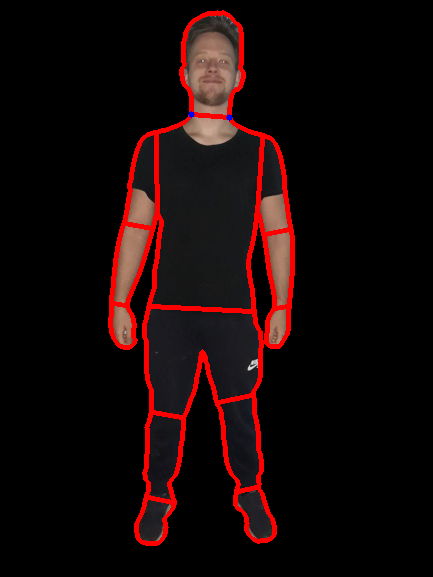

In [0]:
from IPython.display import Image, display

#choose ex1.jpg, ex2.jpg, ex3.jpg or ex4.jpg
# image_path = './ex1.jpg'
image_path = no_bg_path
new_img, humans = pose_estimate(image_path, fill_white=False)
new_img_path = './'+'estimated_'+ image_path[3:]
print(new_img_path)
cv2.imwrite(new_img_path, new_img)
display(Image(new_img_path))

In [0]:
# to download the processed image
files.download(new_img_path)